Fitting 5 folds for each of 5 candidates, totalling 25 fits
Millor alpha (Ridge) trobat amb cross-val sobre TRAIN: 0.01

--- AVALUACIÓ EN VALIDATION SET ---
Validation   → RMSE: 0.7312 | MAE: 0.5716 | R²: 0.9985 | MAPE: 0.38%

--- AVALUACIÓ EN TEST SET (Reentrenat amb Train+Val) ---
Test         → RMSE: 1.0119 | MAE: 0.7914 | R²: 0.9971 | MAPE: 0.40%


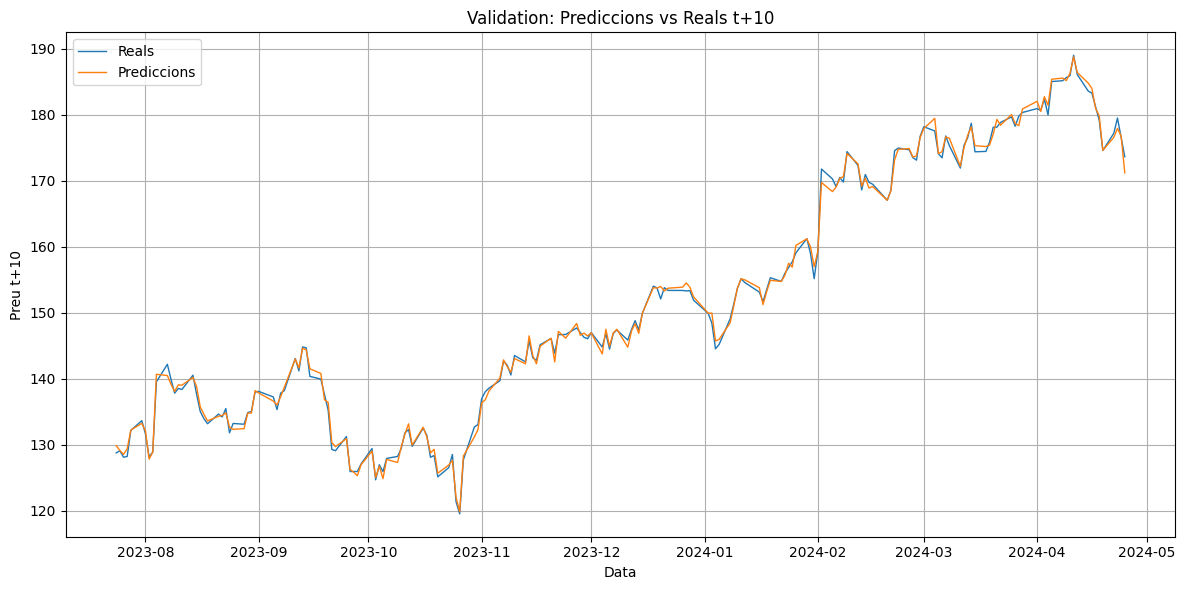

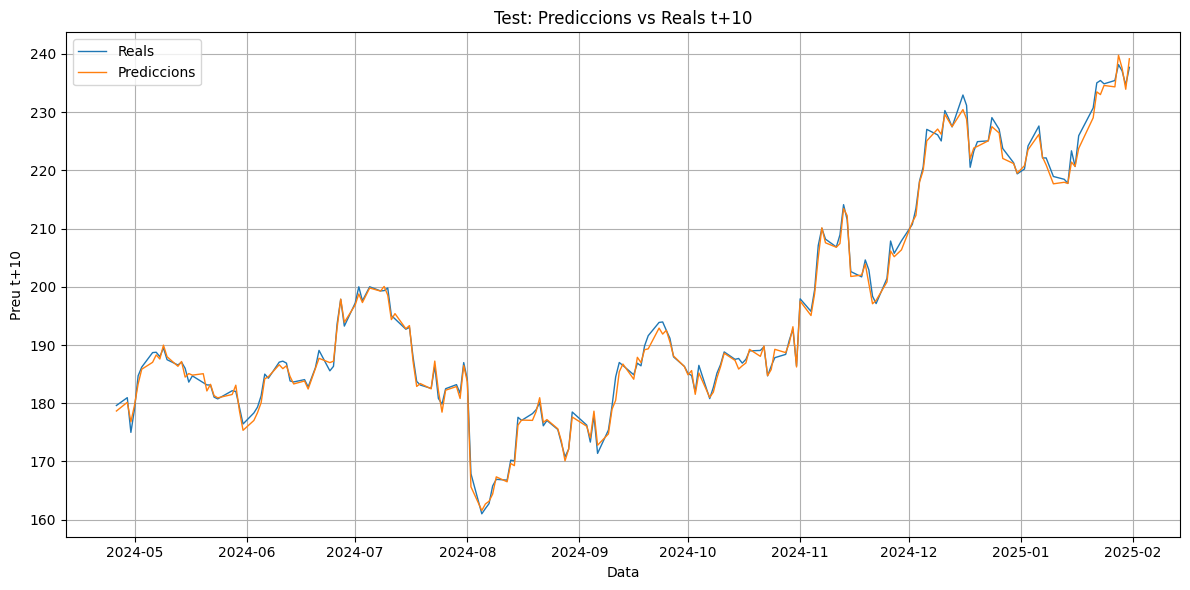


Model final guardat a:
C:\Users\jesus\Desktop\TFG\Models\ridge_model_amazon.joblib


In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------------------
# CONFIGURACIÓ D’ENTORN I PATHS
# ------------------------------------------------------------
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
FILE_NAME = "Amazon_Stock_Price_output.csv"
MODEL_OUTPUT_PATH = r"C:\Users\jesus\Desktop\TFG\Models"
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
MODEL_FILENAME = os.path.join(MODEL_OUTPUT_PATH, "ridge_model_amazon.joblib")

# ------------------------------------------------------------
# FUNCIONS AUXILIARS
# ------------------------------------------------------------
def load_and_prepare_data(csv_path, horizon=10, base_features=None):
    """
    Llegeix el CSV, ordena per data, afegeix el target t+horizon i retorna X, y.
    """
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Si no es passen features, s'utilitzen aquestes per defecte
    if base_features is None:
        base_features = [
            'Open', 'High', 'Low', 'Volume',
            'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
            'MACD_Hist', 'RSI', 'ATR'
        ]

    # Creació del target a 10 dies
    df['Target_Close_t_plus_10'] = df['Close'].shift(-horizon)

    # Eliminar files sense target
    df = df.dropna(subset=['Target_Close_t_plus_10']).reset_index(drop=True)

    X = df[base_features].copy()
    y = df['Target_Close_t_plus_10'].copy()

    return X, y, df

def train_val_test_split_time_series(X, y, train_frac=0.70, val_frac=0.15):
    """
    Fa split cronològic: train, validation i test.
    """
    n_total = len(X)
    split_train = int(n_total * train_frac)
    split_val = int(n_total * (train_frac + val_frac))

    X_train = X.iloc[:split_train].reset_index(drop=True)
    y_train = y.iloc[:split_train].reset_index(drop=True)

    X_val = X.iloc[split_train:split_val].reset_index(drop=True)
    y_val = y.iloc[split_train:split_val].reset_index(drop=True)

    X_test = X.iloc[split_val:].reset_index(drop=True)
    y_test = y.iloc[split_val:].reset_index(drop=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

def evaluate_model(model, X, y_true, subset_name="Subset"):
    """
    Calcula RMSE, MAE, R2 i MAPE, i imprimeix per subset.
    Retorna prediccions i diccionari de mètriques.
    """
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = mean_absolute_error(y_true, preds)
    r2  = r2_score(y_true, preds)
    mape = np.mean(np.abs((y_true - preds) / y_true)) * 100

    print(f"{subset_name:12s} → RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")
    return preds, {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

def plot_predictions(df_full, y_true, y_pred, split_index, title="Prediccions vs Reals"):
    """
    Plota en un gràfic els valors reals vs. prediccions a partir d'un DataFrame complet
    i l'índex on comença el subset (per exemple, inici del test o valid).
    """
    dates = df_full['Date'].iloc[split_index:split_index+len(y_true)]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true.values, label='Reals', linewidth=1)
    plt.plot(dates, y_pred,     label='Prediccions', linewidth=1)
    plt.xlabel("Data")
    plt.ylabel("Preu t+10")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 1. CARREGAR I PREPARAR DADES
# ------------------------------------------------------------
csv_path = os.path.join(BASE_PATH, FILE_NAME)
base_features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
X, y, df_full = load_and_prepare_data(csv_path, horizon=10, base_features=base_features)

# ------------------------------------------------------------
# 2. SPLIT CRONOLÒGIC
# ------------------------------------------------------------
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_time_series(X, y)

# ------------------------------------------------------------
# 3. PIPELINE I GRID SEARCH AMB CROSS-VALIDATION TEMPORAL
# ------------------------------------------------------------
# Definim Pipeline: escalar + model Ridge
from sklearn.pipeline import Pipeline

random_state = 42  # per reproducibilitat

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=random_state))
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Fem TimeSeriesSplit exclusivament sobre TRAIN
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Millor alpha (Ridge) trobat amb cross-val sobre TRAIN: {best_alpha}")

# Recuperem el millor pipeline
best_pipeline = grid_search.best_estimator_

# ------------------------------------------------------------
# 4. AVALUACIÓ SOBRE VALIDATION
# ------------------------------------------------------------
print("\n--- AVALUACIÓ EN VALIDATION SET ---")
preds_val, metrics_val = evaluate_model(best_pipeline, X_val, y_val, subset_name="Validation")

# Si vols, pots decidir reentrenar el model sobre TRAIN+VALIDATION abans de fer el test final
# Per exemple, recomanable si l’objectiu és obtenir el millor model possible
# Construïm un pipeline nou amb el millor alpha i el reentrenem
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha, random_state=random_state))
])
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
final_pipeline.fit(X_train_val, y_train_val)

# ------------------------------------------------------------
# 5. AVALUACIÓ FINAL SOBRE TEST
# ------------------------------------------------------------
print("\n--- AVALUACIÓ EN TEST SET (Reentrenat amb Train+Val) ---")
preds_test, metrics_test = evaluate_model(final_pipeline, X_test, y_test, subset_name="Test")

# ------------------------------------------------------------
# 6. PLOT DE RESULTATS (VAL I TEST)
# ------------------------------------------------------------
# Obtenim l'índex numerós on comença validation i test en df_full
split_train_idx = len(X_train)
split_val_idx = split_train_idx + len(X_val)

# Plot Validation (només per consistència si vols comparar directament)
plot_predictions(df_full, y_val, preds_val, split_train_idx, title="Validation: Prediccions vs Reals")

# Plot Test
plot_predictions(df_full, y_test, preds_test, split_val_idx, title="Test: Prediccions vs Reals")

# ------------------------------------------------------------
# 7. GUARDAT DEL MODEL FINAL
# ------------------------------------------------------------
joblib.dump(final_pipeline, MODEL_FILENAME)
print(f"\nModel final guardat a:\n{MODEL_FILENAME}")


Codi correcte

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------------------
# CONFIGURACIÓ D’ENTORN I PATHS
# ------------------------------------------------------------
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
DATASETS = [
    "Amazon_Stock_Price_output.csv",
    "Euro_Stoxx_50_Stock_Price_output.csv",
    "Google_Stock_Price_output.csv",
    "Hang_Seng_Stock_Price_output.csv",
    "IBEX_35_Stock_Price_output.csv",
    "Indra_Stock_Price_output.csv",
    "P&G_Stock_Price_output.csv",
    "S&P500_Stock_Price_output.csv"
]

BASE_RESULTS_FOLDER = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE"
os.makedirs(BASE_RESULTS_FOLDER, exist_ok=True)

# Paràmetres
RIDGE_PARAM_GRID = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
RANDOM_STATE     = 42
HORIZON          = 10

BASE_FEATURES = [
    'Open','High','Low','Volume',
    'EMA_7','EMA_40','MACD','Signal_Line',
    'MACD_Hist','RSI','ATR'
]

# ------------------------------------------------------------
# FUNCIONS AUXILIARS
# ------------------------------------------------------------
def recompute_indicators(df):
    close = df['Close']
    df['EMA_7']  = close.ewm(span=7,  adjust=False).mean()
    df['EMA_40'] = close.ewm(span=40, adjust=False).mean()
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd  = ema12 - ema26
    signal= macd.ewm(span=9, adjust=False).mean()
    df['MACD']        = macd
    df['Signal_Line'] = signal
    df['MACD_Hist']   = macd - signal
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_g = gain.ewm(alpha=1/14, adjust=False).mean()
    avg_l = loss.ewm(alpha=1/14, adjust=False).mean()
    rs    = avg_g / (avg_l + 1e-8)
    df['RSI'] = 100 - (100 / (1 + rs))
    df['ATR'] = (df['High'] - df['Low']).rolling(window=14).mean()


def load_and_prepare_data(csv_path, horizon=HORIZON, base_features=BASE_FEATURES):
    """
    - Recalcula indicadors
    - Crea Target i Target_Date shiftats -horizon
    - Dropna de features + Target + Target_Date
    - Retorna X, y, df_prepared (amb Date i Target_Date)
    """
    df = (
        pd.read_csv(csv_path, parse_dates=['Date'])
        .sort_values('Date')
        .reset_index(drop=True)
    )

    recompute_indicators(df)

    # target i data de target
    df['Target']      = df['Close'].shift(-horizon)
    df['Target_Date'] = df['Date'].shift(-horizon)

    # neteja NaN
    df = df.dropna(subset=base_features + ['Target', 'Target_Date']).reset_index(drop=True)

    X = df[base_features].copy()
    y = df['Target'].copy()
    return X, y, df


def train_val_test_split_time_series(X, y, train_frac=0.70, val_frac=0.15):
    n       = len(X)
    i_train = int(n * train_frac)
    i_val   = int(n * (train_frac + val_frac))

    X_tr, y_tr = X.iloc[:i_train],    y.iloc[:i_train]
    X_va, y_va = X.iloc[i_train:i_val], y.iloc[i_train:i_val]
    X_te, y_te = X.iloc[i_val:],       y.iloc[i_val:]

    return (
        X_tr.reset_index(drop=True), y_tr.reset_index(drop=True),
        X_va.reset_index(drop=True), y_va.reset_index(drop=True),
        X_te.reset_index(drop=True), y_te.reset_index(drop=True)
    )


def evaluate_and_save_metrics(model, X, y_true, subset_name, folder, ds_name):
    preds = model.predict(X)
    rmse  = np.sqrt(mean_squared_error(y_true, preds))
    mae   = mean_absolute_error(y_true, preds)
    r2    = r2_score(y_true, preds)

    dfm = pd.DataFrame({
        "Model": [f"Ridge_{subset_name}"],
        "RMSE":  [rmse],
        "MAE":   [mae],
        "R2":    [r2]
    })
    dfm.to_csv(os.path.join(folder, f"{ds_name}_{subset_name.lower()}_metrics.csv"), index=False)
    return preds


def plot_real_vs_pred(dates, y_true, y_pred, title, out_path):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=y_true, mode='lines', name='Real (Close)', line=dict(color='blue')))
    fig.add_trace(go.Scatter(
        x=dates, y=y_pred,
        mode='lines', name='Predit',
        line=dict(dash='dash')
    ))
    fig.update_layout(
        title=title,
        xaxis_title='Data',
        yaxis_title=f'Preu (Close)',
        template='plotly_white',
        xaxis_rangeslider_visible=True
    )
    fig.write_html(out_path)


# ------------------------------------------------------------
# PROCÉS PER A CADA DATASET
# ------------------------------------------------------------
for fname in DATASETS:
    path = os.path.join(BASE_PATH, fname)
    ds   = os.path.splitext(fname)[0]
    out  = os.path.join(BASE_RESULTS_FOLDER, ds)
    os.makedirs(out, exist_ok=True)

    # 1) Carregar i preparar
    X, y, df_prep = load_and_prepare_data(path)
    dates_feat    = df_prep['Date']
    dates_tgt     = df_prep['Target_Date']

    # 2) Split cronològic
    X_tr, y_tr, X_va, y_va, X_te, y_te = train_val_test_split_time_series(X, y)
    i_tr = len(X_tr)
    i_va = len(X_va)

    # 3) GridSearchCV (Ridge)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=RANDOM_STATE))
    ])
    tscv = TimeSeriesSplit(n_splits=5)
    gs   = GridSearchCV(
        pipe,
        param_grid=RIDGE_PARAM_GRID,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    gs.fit(X_tr, y_tr)
    best_alpha = gs.best_params_['ridge__alpha']
    best_pipe  = gs.best_estimator_

    # 4) Avaluar Validation
    preds_va = evaluate_and_save_metrics(best_pipe, X_va, y_va, "Validation", out, ds)

    # 5) Entrenar final + Test
    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=best_alpha, random_state=RANDOM_STATE))
    ])
    X_trval = pd.concat([X_tr, X_va], axis=0).reset_index(drop=True)
    y_trval = pd.concat([y_tr, y_va], axis=0).reset_index(drop=True)
    final_pipe.fit(X_trval, y_trval)

    # Test (amb metrics)
    preds_te = evaluate_and_save_metrics(final_pipe, X_te, y_te, "Test", out, ds)

    # 6) Desar model
    joblib.dump(final_pipe, os.path.join(out, f"{ds}_ridge_model.joblib"))

    # 7) Gràfics Validation i Test fins a last Target_Date
    #    → ara fem servir dates_tgt per al test perquè arribi fins a l'últim dia real
    plot_real_vs_pred(
        dates_tgt.iloc[i_tr:i_tr+i_va], y_va, preds_va,
        f"{ds} – Validation (Ridge)",
        os.path.join(out, f"{ds}_validation.html")
    )
    plot_real_vs_pred(
        dates_tgt.iloc[i_tr+i_va:], y_te, preds_te,
        f"{ds} – Real vs Predicció (Test, RIDGE REGRESSION)",
        os.path.join(out, f"{ds}_test.html")
    )

    # 8) PREDICCIÓ AUTOREGRESSIVA FUTURS 10 DIES (només els primers 10 dies després)
    df_full = (
        pd.read_csv(path, parse_dates=['Date'])
        .sort_values('Date')
        .reset_index(drop=True)
    )
    recompute_indicators(df_full)
    df_full = df_full.dropna(subset=BASE_FEATURES).reset_index(drop=True)

    last_date   = df_full['Date'].iloc[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=HORIZON)
    future_preds = []

    df_fut = df_full.copy().reset_index(drop=True)
    for dt in future_dates:
        X_last = df_fut[BASE_FEATURES].tail(1)
        y_p    = final_pipe.predict(X_last)[0]
        future_preds.append(y_p)

        prev = df_fut.iloc[-1]
        new_row = {
            'Date':  dt,
            'Open':  prev['Close'],
            'High':  y_p,
            'Low':   y_p,
            'Volume': prev['Volume'],
            'Close': y_p,
            **{f: np.nan for f in BASE_FEATURES if f not in ['Open','High','Low','Volume']}
        }
        df_fut = pd.concat([df_fut, pd.DataFrame([new_row])], ignore_index=True)
        recompute_indicators(df_fut)

    # Guardar CSV i HTML de futurs
    pd.DataFrame({
        "Date": future_dates,
        "Pred_Close_Ridge": future_preds
    }).to_csv(os.path.join(out, f"{ds}_future_10days_ridge.csv"), index=False)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_full['Date'], y=df_full['Close'], mode='lines', name='Històric (Close)', line=dict(color='lightblue')
    ))
    fig.add_trace(go.Scatter(
        x=future_dates, y=future_preds,
        mode='lines+markers', name='Predicció futura',
        line=dict(color='orange', dash='dash')
    ))
    fig.update_layout(
        title=f"{ds} – Predicció Pròxims 10 dies (RIDGE REGRESSION)",
        xaxis_title='Data', yaxis_title='Close',
        template='plotly_white', xaxis_rangeslider_visible=True
    )
    fig.write_html(os.path.join(out, f"{ds}_future_plot_ridge.html"))

    print(f"✓ Finalitzat {ds}")

print("Procés completat per a tots els datasets.")


✓ Finalitzat Amazon_Stock_Price_output
✓ Finalitzat Euro_Stoxx_50_Stock_Price_output
✓ Finalitzat Google_Stock_Price_output
✓ Finalitzat Hang_Seng_Stock_Price_output
✓ Finalitzat IBEX_35_Stock_Price_output
✓ Finalitzat Indra_Stock_Price_output
✓ Finalitzat P&G_Stock_Price_output
✓ Finalitzat S&P500_Stock_Price_output
Procés completat per a tots els datasets.
